In [2]:
# import relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PowerTransformer

In [3]:
# import dataset
df = pd.read_excel('ACF_PACF_results.xlsx')
subset, rest = train_test_split(df, test_size=0.80, random_state=42, shuffle=True)

In [4]:
labels = subset[["p", "q"]]

df_subset = subset.iloc[:, 6:]

df_subset.iloc[:, 40:] 

subset.iloc[:, 1:54] 


,p,q,w,j,T,ACF_0,ACF_1,ACF_2,ACF_3,ACF_4,...,ACF_38,ACF_39,ACF_40,PACF_0,PACF_1,PACF_2,PACF_3,PACF_4,PACF_5,PACF_6
3167,4,1,35,9,1000,1,0.738467,0.551230,0.396798,0.315158,...,-0.017934,-0.002013,0.002587,1,0.738481,0.012971,-0.032318,0.065167,0.001827,0.021262
1809,3,5,13,6,1000,1,0.824856,0.618050,0.488122,0.397734,...,-0.017665,0.004207,0.033731,1,0.825302,-0.196881,0.130631,-0.009209,0.023726,-0.040011
16785,2,5,41,5,1000,1,-0.918208,0.747238,-0.577496,0.444527,...,0.015333,-0.018443,0.032438,1,-0.920200,-0.620703,-0.351553,-0.135119,-0.045226,0.054083
7161,5,2,45,3,1000,1,0.761499,0.551066,0.425653,0.302549,...,-0.061881,-0.035751,-0.026056,1,0.761951,-0.069904,0.069081,-0.072105,0.073270,-0.046503
9456,0,4,31,8,1000,1,0.517110,-0.081083,-0.109726,0.004380,...,-0.006130,-0.056344,-0.059915,1,0.517120,-0.476003,0.350092,-0.270167,0.240536,-0.165665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,1,1,46,4,1000,1,0.381788,0.339480,0.297659,0.287759,...,0.032321,0.044957,0.060629,1,0.382002,0.226678,0.137027,0.118430,0.071717,0.041698
11964,1,3,7,6,1000,1,0.467645,0.072057,0.047322,0.055689,...,-0.010541,0.035896,0.048800,1,0.467665,-0.187689,0.126841,-0.016138,-0.002218,0.021225
5390,0,2,49,5,1000,1,-0.137387,0.305169,-0.029486,0.025901,...,0.027291,-0.032207,0.001263,1,-0.137475,0.292017,0.045038,-0.068935,-0.080402,0.009954
860,3,3,28,2,1000,1,0.878505,0.621119,0.384258,0.218427,...,0.014713,0.036552,0.052084,1,0.878598,-0.668320,0.457481,-0.341421,0.273408,-0.173005


PCA reduced the dataset to 22 features to retain 95% of the variance.


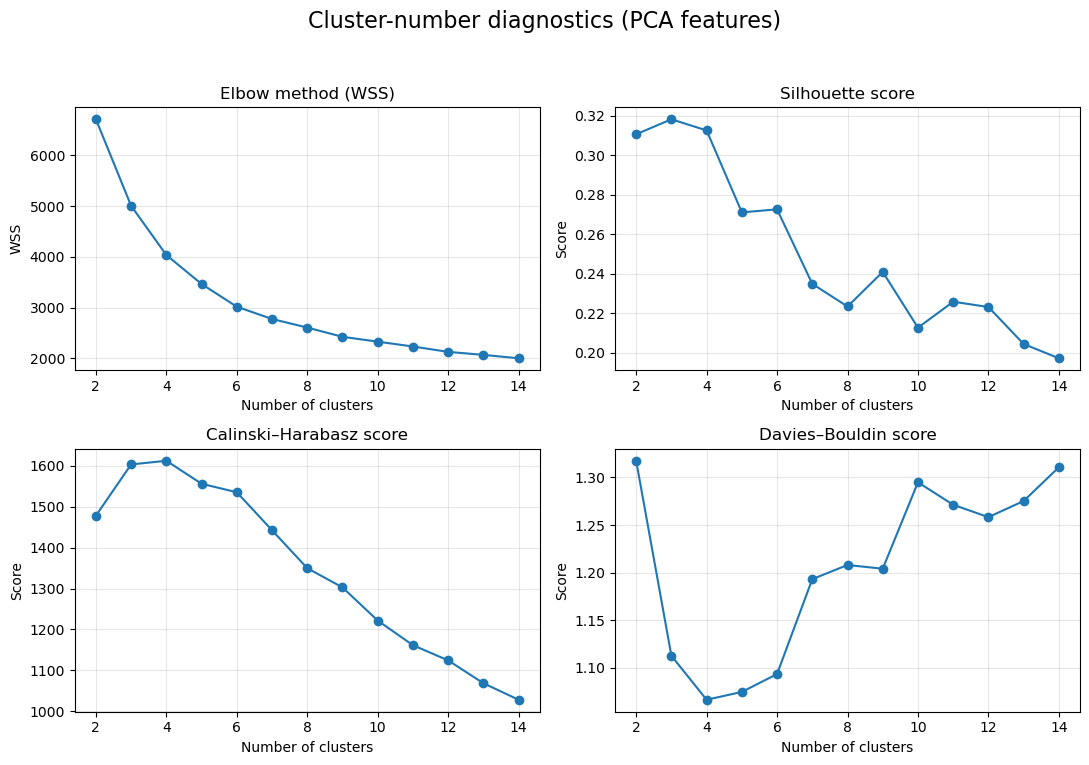

In [5]:
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore", message=".*KMeans is known to have a memory leak.*")

# ----- PCA: Fit and Transform -----
# Fit PCA to retain 95% of variance
pca_full = PCA(svd_solver="full").fit(df_subset)
expl_var = pca_full.explained_variance_ratio_
cum_var = expl_var.cumsum()
k = cum_var.searchsorted(0.95) + 1
print(f"PCA reduced the dataset to {k} features to retain 95% of the variance.")

# Transform to k principal components
pca = PCA(n_components=k, svd_solver="full")
df_pca = pca.fit_transform(df_subset)

# ----- elbow -----------------------------------------------------------
wss = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_pca)
    wss.append(kmeans.inertia_)

# ----- silhouette ------------------------------------------------------
silhouette_scores = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_pca)
    silhouette_scores.append(metrics.silhouette_score(df_pca, kmeans.labels_))

# ----- Calinski–Harabasz & Davies–Bouldin -----------------------------
ch_scores, db_scores = [], []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_pca)
    ch_scores.append(metrics.calinski_harabasz_score(df_pca, kmeans.labels_))
    db_scores.append(metrics.davies_bouldin_score(df_pca, kmeans.labels_))

# ----- Plotting --------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(11, 8))
fig.suptitle('Cluster-number diagnostics (PCA features)', fontsize=16)

# (0,0) Elbow
axes[0, 0].plot(range(2, 15), wss, marker='o')
axes[0, 0].set_title('Elbow method (WSS)')
axes[0, 0].set_xlabel('Number of clusters')
axes[0, 0].set_ylabel('WSS')

# (0,1) Silhouette
axes[0, 1].plot(range(2, 15), silhouette_scores, marker='o')
axes[0, 1].set_title('Silhouette score')
axes[0, 1].set_xlabel('Number of clusters')
axes[0, 1].set_ylabel('Score')

# (1,0) Calinski–Harabasz
axes[1, 0].plot(range(2, 15), ch_scores, marker='o')
axes[1, 0].set_title('Calinski–Harabasz score')
axes[1, 0].set_xlabel('Number of clusters')
axes[1, 0].set_ylabel('Score')

# (1,1) Davies–Bouldin
axes[1, 1].plot(range(2, 15), db_scores, marker='o')
axes[1, 1].set_title('Davies–Bouldin score')
axes[1, 1].set_xlabel('Number of clusters')
axes[1, 1].set_ylabel('Score')

for ax in axes.flat:
    ax.grid(alpha=0.3)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()


In [6]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
import pandas as pd




results_pca = []
for n_clusters in [4, 5, 6]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_pca)
    silhouette = metrics.silhouette_score(df_pca, kmeans.labels_)
    ch = metrics.calinski_harabasz_score(df_pca, kmeans.labels_)
    db = metrics.davies_bouldin_score(df_pca, kmeans.labels_)
    results_pca.append({
        'k': n_clusters,
        'Silhouette': silhouette,
        'Calinski-Harabasz': ch,
        'Davies-Bouldin': db
    })

df_results_pca = pd.DataFrame(results_pca)
print("PCA Features Clustering Metrics:")
print(df_results_pca)


PCA Features Clustering Metrics:
   k  Silhouette  Calinski-Harabasz  Davies-Bouldin
0  4    0.312654        1612.726060        1.066383
1  5    0.271099        1556.506261        1.074632
2  6    0.272615        1535.684957        1.093415


In [7]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_pca)

KMeans(n_clusters=4, random_state=42)

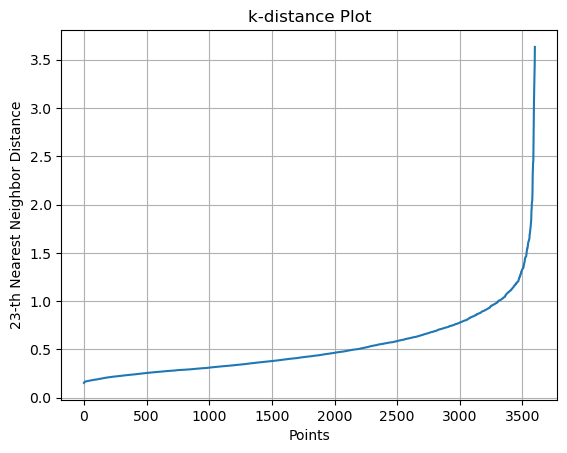

In [26]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np


# DBSCAN 
# we need to define eps (maximum distance between 2 points to be neighbors) and min_samples (minimum number of points that form a dense region)
# rule of thumb for  min_samples = nº features + 1 
# for eps lets compute distances for k-th nearest neighbors
n = 23  # Set n to the number of neighbors you want to consider
nbrs = NearestNeighbors(n_neighbors=n)
nbrs.fit(df_pca)
distances, indices = nbrs.kneighbors(df_pca)

# Sort distances for k-th nearest neighbors
distances = np.sort(distances[:, n-1], axis=0)

# Plot the k-distance graph
plt.plot(distances)
plt.title('k-distance Plot')
plt.xlabel('Points')
plt.ylabel(f'{n}-th Nearest Neighbor Distance')
plt.grid(True)
plt.show()
#The point where the distance starts to increase significantly is often a good value for eps

In [27]:
from sklearn.cluster import DBSCAN

# Assuming X is your data matrix after preprocessing (e.g., scaling, PCA)
dbscan = DBSCAN(eps=1.3, min_samples=23)  # Adjust eps and min_samples as needed
dbscan.fit(df_pca)

labels = dbscan.labels_  # Cluster labels (-1 means noise)

In [28]:
print(set(labels))

{0, -1}


## Aglomerative clustering 

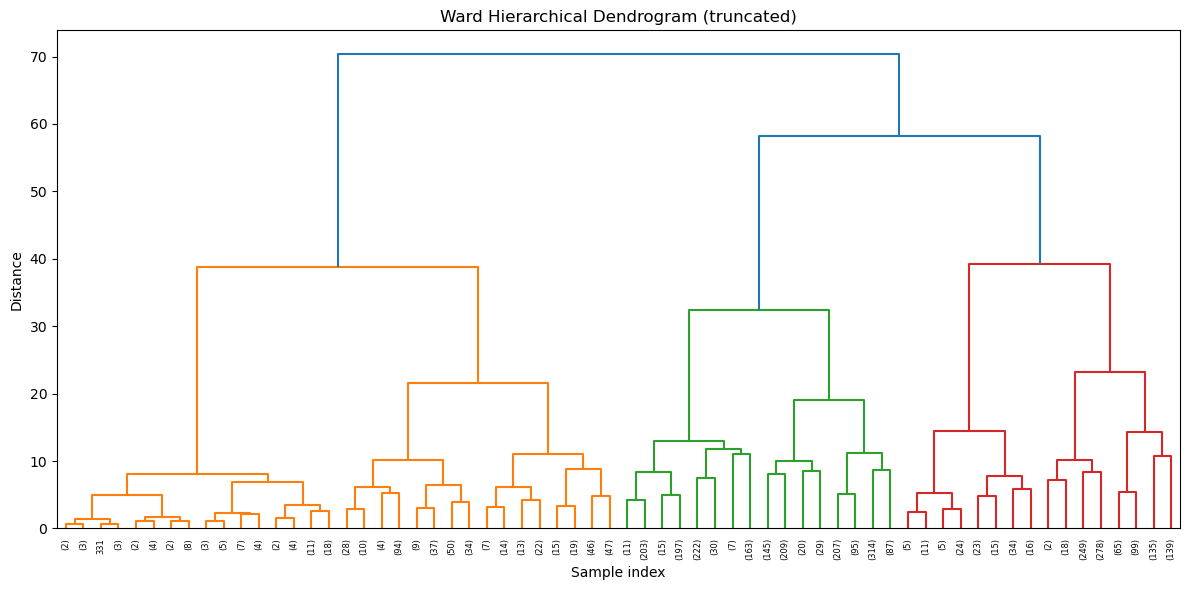

In [25]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import (silhouette_score, davies_bouldin_score,
                             calinski_harabasz_score, adjusted_rand_score,
                             normalized_mutual_info_score, accuracy_score,
                             confusion_matrix)

Z = linkage(df_pca, method='ward')  

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=5)  
plt.title('Ward Hierarchical Dendrogram (truncated)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()


In [29]:
import numpy as np
import pandas as pd
from sklearn import metrics

y_true = (subset['p'] * 6 + subset['q']).to_numpy()
# Example: replace these with your actual labels and data
labels_kmeans = kmeans.labels_
labels_dbscan = dbscan.labels_ 
labels_hier = fcluster(Z, 4, criterion='maxclust') - 1 
X_pca = df_pca

def get_cluster_metrics(algo, labels, X):
    # Number of clusters (excluding noise if present, i.e., label == -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # Percentage of noise points (for DBSCAN, else 0)
    noise_pct = np.mean(labels == -1) if -1 in labels else 0.0
    # Compute metrics (ignore noise for silhouette etc.)
    mask = labels != -1
    sil = metrics.silhouette_score(X[mask], labels[mask]) if n_clusters > 1 and np.sum(mask) > 1 else np.nan
    dbi = metrics.davies_bouldin_score(X[mask], labels[mask]) if n_clusters > 1 and np.sum(mask) > 1 else np.nan
    ch = metrics.calinski_harabasz_score(X[mask], labels[mask]) if n_clusters > 1 and np.sum(mask) > 1 else np.nan
    # For ARI, NMI, Purity you need ground truth labels (replace y_true as needed)
    ari = metrics.adjusted_rand_score(y_true[mask], labels[mask]) if 'y_true' in globals() else np.nan
    nmi = metrics.normalized_mutual_info_score(y_true[mask], labels[mask]) if 'y_true' in globals() else np.nan
    # Purity calculation (if you have y_true)
    if 'y_true' in globals():
        contingency = metrics.cluster.contingency_matrix(y_true[mask], labels[mask])
        purity = np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)
    else:
        purity = np.nan
    return {
        'Algo': algo,
        'k': n_clusters,
        'noise_pct': round(noise_pct, 3),
        'Sil': round(sil, 3) if not np.isnan(sil) else None,
        'DBI': round(dbi, 3) if not np.isnan(dbi) else None,
        'CH': round(ch, 3) if not np.isnan(ch) else None,
        'ARI': round(ari, 3) if not np.isnan(ari) else None,
        'NMI': round(nmi, 3) if not np.isnan(nmi) else None,
        'Purity': round(purity, 3) if not np.isnan(purity) else None
    }

# Collect metrics for all models
results = [
    get_cluster_metrics('k-means', labels_kmeans, X_pca),
    get_cluster_metrics('DBSCAN', labels_dbscan, X_pca),
    get_cluster_metrics('Hier-Ward', labels_hier, X_pca)
]

# Create DataFrame
df_metrics = pd.DataFrame(results)
print(df_metrics)


        Algo  k  noise_pct    Sil    DBI        CH    ARI    NMI  Purity
0    k-means  4      0.000  0.313  1.066  1612.726  0.006  0.047   0.058
1     DBSCAN  1      0.009    NaN    NaN       NaN  0.000  0.000   0.031
2  Hier-Ward  4      0.000  0.288  1.104  1305.060  0.005  0.047   0.052
